In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def processing(df):
    print(f'처리 전 데이터 개수 : {len(df)}')
    # 중복, null 값 제거
    df = df.drop_duplicates(subset=['document'])
    df = df.dropna(how = 'any')
    
    # 한글과 공백을 제외하고 모두 제거
    df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)

    # 한글만 있는 리뷰 정제
    df['document'] = df['document'].str.replace('^ +', "")

    # 비어있는 값을 null 값 처리
    df['document'].replace('', np.nan, inplace=True)

    # Null 값 처리
    df.dropna(how = 'any', inplace = True)
    print(f'처리 후 데이터 개수 : {len(df)}')
    return df.reset_index(drop = True)


def stopwords_morphs(df):
    # 불용어 정의
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

    # Okt 형태소 분석기
    okt = Okt()

    result = []
    for sentence in tqdm(df['document']):
        tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
        result.append(stopwords_removed_sentence)
    return result

In [2]:
import pandas as pd
train = pd.read_table('./data/ratings_train.txt')
test = pd.read_table('./data/ratings_test.txt')

In [3]:
# 전처리
train = processing(train)
test = processing(test)

처리 전 데이터 개수 : 150000
처리 후 데이터 개수 : 145791
처리 전 데이터 개수 : 50000
처리 후 데이터 개수 : 48995


In [4]:
# 불용어 처리, 형태소 분리
X_train = stopwords_morphs(train)
X_test = stopwords_morphs(test)

100%|██████████| 48995/48995 [06:53<00:00, 118.54it/s]


In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

AttributeError: 'int' object has no attribute 'lower'

In [16]:
print(tokenizer.word_index)

{}


In [7]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [8]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [9]:
# 단어 집합의 크기는 19,416개입니다. 이를 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환합니다.
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [10]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


In [11]:
y_train = np.array(train['label'])
y_test = np.array(test['label'])

In [12]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


c:\Users\wjddm\anaconda3\envs\nlp\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


# 패딩

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


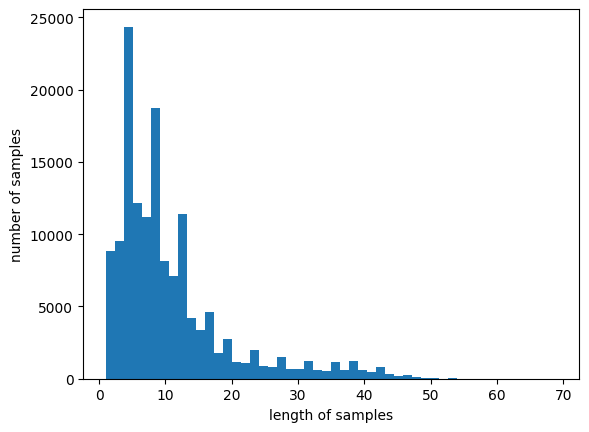

In [13]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [17]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [18]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [19]:
# tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1815/1815 [==============================] - ETA: 0s - loss: 0.4089 - acc: 0.8100
Epoch 1: val_acc improved from -inf to 0.83736, saving model to best_model.h5
1815/1815 [==============================] - 104s 56ms/step - loss: 0.4089 - acc: 0.8100 - val_loss: 0.3717 - val_acc: 0.8374
Epoch 2/15
1815/1815 [==============================] - ETA: 0s - loss: 0.3463 - acc: 0.8495
Epoch 2: val_acc improved from 0.83736 to 0.84456, saving model to best_model.h5
1815/1815 [==============================] - 104s 57ms/step - loss: 0.3463 - acc: 0.8495 - val_loss: 0.3520 - val_acc: 0.8446
Epoch 3/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.3200 - acc: 0.8627
Epoch 3: val_acc improved from 0.84456 to 0.85244, saving model to best_model.h5
1815/1815 [==============================] - 99s 54ms/step - loss: 0.3200 - acc: 0.8627 - val_loss: 0.3390 - val_acc: 0.8524
Epoch 4/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.2974 - acc: 0.8754
Epoch 4: va

In [27]:
# # # 토크나이저 업로드
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

# 토크나이저 다운로드

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
okt = Okt()
max_len = 30
with open('./models/tokenizer.pickle', 'rb') as handle:
     tokenizer = pickle.load(handle)
     
loaded_model = load_model('./models/best_model.h5')

In [28]:


stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  print(score)
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다./n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다./n".format((1 - score) * 100))


In [29]:
sentiment_predict('아이랑 같이 다녀왔어요. 그런데 생각보다 실망을 좀 했어요. 맛이 좋은 것 같다가도, 조금 난해하네요. 여튼 저는 다시 가진 않을 것 같네요')

1/1 [==============================] - 1s 509ms/step
0.6432832479476929
64.33% 확률로 긍정 리뷰입니다./n
